In [31]:
# all libraries required for making the plots
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta
from datasets import Dataset
from util import Annotation
import json
from pprint import pprint


colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [43]:
# process annotations into a dataset
with open('./annotations/all_annotations.json', 'r', encoding='UTF-8') as inp:
    annotations_json = json.load(inp)

annotations = [Annotation(annotation) for annotation in annotations_json]
dataset = Dataset.from_list(
    [
        {'id': index, **annotation.get_events_training_data()}
        for index, annotation in enumerate(annotations)
    ]
)

pprint(dataset)

Dataset({
    features: ['id', 'event_tags', 'tokens'],
    num_rows: 4806
})
4806


In [46]:
# compute label distribution in annotations
id2label = {
    0: 'O',
    1: 'nonrealis',
    2: 'realis',
}

all_annotation_ids = []

for annotation in dataset:
    all_annotation_ids += annotation['event_tags']
    
annotation_counts = {label:all_annotation_ids.count(key) for key, label in id2label.items()}
annotation_counts['events_total'] = annotation_counts['realis'] + annotation_counts['nonrealis']
print(f'annotation counts: {annotation_counts}')

annotation_counts_average = {label: round(count/len(dataset),3) for label, count in annotation_counts.items()}
print(f'annotation counts average per annotation: {annotation_counts_average}')

annotation counts: {'O': 76991, 'nonrealis': 2576, 'realis': 7582, 'events_total': 10158}
annotation counts average per annotation: {'O': 16.02, 'nonrealis': 0.536, 'realis': 1.578, 'events_total': 2.114}


In [154]:
df = pd.DataFrame.from_dict(annotation_counts, orient='index')
df.columns = ['occurences']
df.index.name = 'label'

df[1:-1]

# use this code to print label distribution to a table
# df[1:-1].style.to_latex(label='label distribution')

,occurences
label,
nonrealis,2576
realis,7582


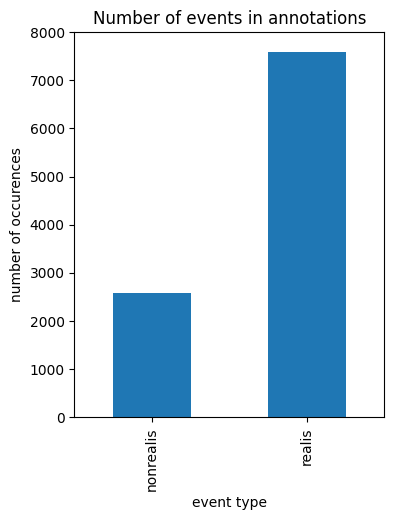

In [155]:
# plot label distribution

plot = df[1:-1].plot(kind='bar', xlabel='event type', ylabel='number of occurences', legend=False, ylim=(0,8000), figsize=(4, 5), title='Number of events in annotations')

In [152]:
# label distribution average

df = pd.DataFrame.from_dict(annotation_counts_average, orient='index')
df.columns = ['avg occurences per annotation']
df.index.name = 'label'

df

# use this code to print label distribution to a table
# df.style.to_latex(label='label distribution')

,avg occurences per annotation
label,
O,16.020
nonrealis,0.536
realis,1.578
events_total,2.114


<Axes: title={'center': 'Event type distribution per annotation'}, xlabel='event type', ylabel='number of occurences'>

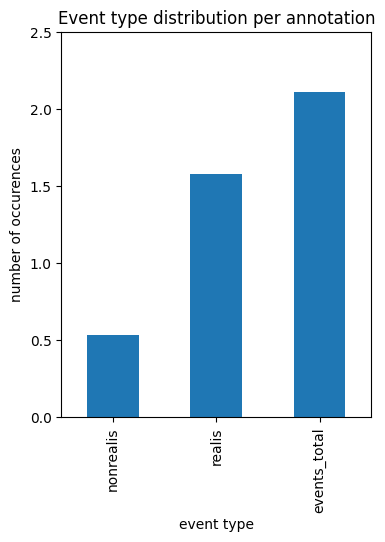

In [153]:
# plot average label distribution per annotation

df[1:].plot(kind='bar', xlabel='event type', ylabel='number of occurences', legend=False, ylim=(0,2.5), figsize=(4, 5), title='Event type distribution per annotation')

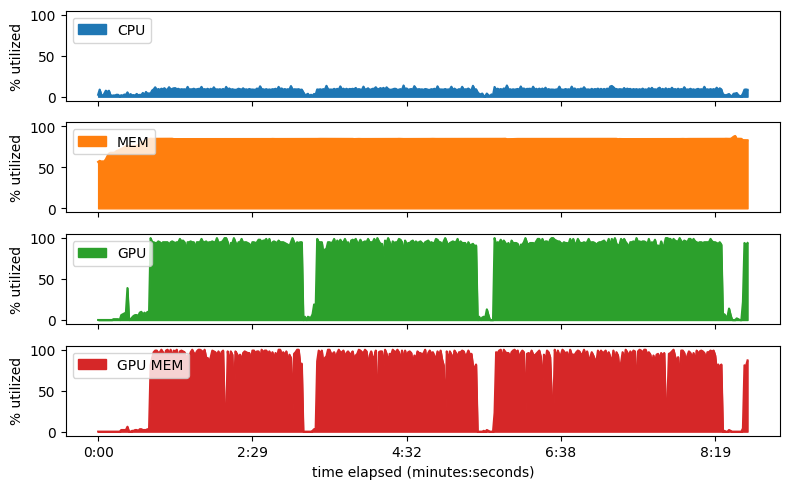

In [61]:
# resource usage with GPU
df = pd.read_csv('./logs/resource_usage_gpu.log', sep='\t', header=0, index_col=False, comment='#')

df['time_formatted'] = df['time'].apply(lambda x: f"{int(x // 60)}:{int(x % 60):02d}")

fig, axes = plt.subplots(figsize=(8, 5), nrows=len(df.columns[1:-1]), sharey=True, sharex=True)


for i, column in enumerate(df.columns[1:-1]):
    if column != 'time_formatted':
        df.plot.area(ax=axes[i], color=colors[i], x='time_formatted', y=column, xlabel='time elapsed (minutes:seconds)', ylabel='% utilized')
        
        axes[i].legend(loc='upper left')

        
plt.tight_layout()
plt.show()


In [132]:
# fine-tuned BERTJE 0.9 train 0.1 test results table

results = {
    'realis': 
        {
            'f1': 0.85137861466039,
            'number': 736,
            'precision': 0.8428761651131824,
            'recall': 0.8600543478260869,
            'accuracy': None,
        },
    'nonrealis': 
        {
            'f1': 0.7246376811594204,
            'number': 253,
            'precision': 0.7608695652173914,
            'recall': 0.691699604743083,
            'accuracy': None,
        },
    'overall':
        {
            'f1': 0.8203045685279189,
            'precision': 0.8236493374108053,
            'recall': 0.8169868554095046,
            'accuracy': 0.9717144506446026,
        },
    } 

results['overall']['number'] = results['realis']['number'] + results['nonrealis']['number']

df = pd.DataFrame.from_dict(results, orient='index')

df.index.name = 'label'

df = df.round(3)

df

,f1,number,precision,recall,accuracy
label,,,,,
realis,0.851,736,0.843,0.860,NaN
nonrealis,0.725,253,0.761,0.692,NaN
overall,0.820,989,0.824,0.817,0.972


In [135]:
# fine-tuned BERTJE 0.75 train 0.25 test results table

results = {
    'realis': 
        {
            'f1': 0.8375744450460206,
            'number': 1878,
            'precision': 0.8518722466960352,
            'recall': 0.8237486687965921,
            'accuracy': None,
        },
    'nonrealis': 
        {
            'f1': 0.7110091743119267,
            'number': 674,
            'precision': 0.7334384858044164,
            'recall': 0.6899109792284867,
            'accuracy': None,
        },
    'overall': 
        {
            'accuracy': 0.9683312573132525,
            'f1': 0.8044782087165133,
            'precision': 0.8212244897959183,
            'recall': 0.7884012539184952,
        }
}

results['overall']['number'] = results['realis']['number'] + results['nonrealis']['number']

results['overall']['number'] = results['realis']['number'] + results['nonrealis']['number']

df = pd.DataFrame.from_dict(results, orient='index')

df.index.name = 'label'

df = df.round(3)

df

,f1,number,precision,recall,accuracy
label,,,,,
realis,0.838,1878,0.852,0.824,NaN
nonrealis,0.711,674,0.733,0.690,NaN
overall,0.804,2552,0.821,0.788,0.968
